# Stellar SV Area Setup

In [325]:
import os
import sys
import warnings
import subprocess
from   importlib import reload

import astropy
import astropy.units as u
import astropy.coordinates as coord
from   astropy.io import fits
from   astropy.table import Table, Column

import numpy as np

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane

import fitsio

# Add the python scripts associated with this notebook (under ./py)
add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))


# Run an alternate DESItarget out of code directory
WITH_SSV_DESITARGET   = True
SSV_DESITARGET_PATH   = '/global/homes/a/apcooper/desi/code/desitarget/py/'
SSV_DESITARGET_BRANCH = 'stellar_sv'
if WITH_SSV_DESITARGET:
    add_sys_path.append(SSV_DESITARGET_PATH)

    ssv_desitarget_branch = subprocess.getoutput('pushd {} > /dev/null; git rev-parse --symbolic-full-name --abbrev-ref HEAD; popd > /dev/null'.format(SSV_DESITARGET_PATH))
    assert(ssv_desitarget_branch == SSV_DESITARGET_BRANCH)
    
for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.insert(0,_)

# This is the standard desitarget, we will swap it out later
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
    
import desitarget.io as io
import desitarget.mtl

import desitarget.sv1.sv1_targetmask
from   desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask, obsmask

from   desitarget.targetmask import obsconditions

# Local scripts for SSV        
import ssv
from   ssv.plan import Tile, Dither, DitherSet
import ssv.area as sv_area
reload(sv_area)

# Import pyplot last
import matplotlib.pyplot as pl

# Setup directory environment
ROOT_DIR   = os.getcwd()
GLOBAL_DIR = os.path.join(ROOT_DIR,'global')
TILES_DIR  = os.path.join(GLOBAL_DIR,'tiles')
DATA_DIR   = os.path.join(ROOT_DIR,'data')

for _ in [GLOBAL_DIR,TILES_DIR,DATA_DIR]:
    if not os.path.exists(_):
        os.makedirs(_)

In [326]:
pwd

'/global/u1/a/apcooper/projects/ssv_plan'

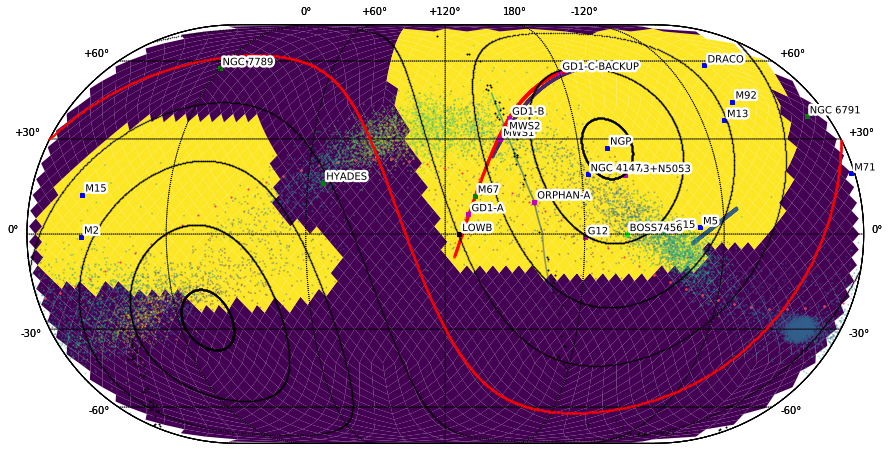

In [327]:
reload(sv_area)
sv_area.plot_footprint(kepler=False,bcontours=[20,40,60,80],streams=['GD-1','Pal5','Sgr-L10','Orphan'],streams_extra=True)

In [328]:
for name, a in sv_area.SSV_AREAS.items():
    c   = a['coord']
    ra  = c.icrs.ra.deg
    dec = c.icrs.dec.deg

    print('{:10s} {:12.6f} {:12.6f}'.format(name,ra,dec))

DRACO        260.051625    57.915361
MWS1         145.000000    30.000000
MWS2         148.000000    32.250000
ORPHAN-A     158.500000    10.000000
G15          217.500000     1.000000
G12          180.000000    -1.000000
M53+N5053    199.000000    18.300000
NGP          192.859478    27.128252
M92          259.280792    43.135944
M13          250.421833    36.459861
M71          298.443708    18.779194
M2           323.362583    -0.823250
M5           229.638417     2.081028
M15          322.493042    12.167000
NGC 4147     182.526250    18.542639
M67          132.825000    11.800000
HYADES        66.725000    15.866667
NGC 6791     290.220833    37.771667
NGC 7789     359.350000    56.708333
GD1-A        130.032207     6.078548
GD1-B        150.024572    37.312332
GD1-C        179.982931    54.664755
GD1-C-BACKUP   179.982931    54.664755
BOSS7456     198.039000     0.000000
LOWB         126.000000     0.000000


In [329]:
_ = list()
for name, a in sv_area.SSV_AREAS.items():
    c = a['coord']
    g = c.galactic
    ra = c.icrs.ra.hms
    _.append((g.galactic.b,name))

for v,k in sorted(_):
    print('{:10s} {:10.5f}'.format(k,v))

M2          -35.76976 deg
M15         -27.31263 deg
HYADES      -22.34295 deg
NGC 7789     -5.38501 deg
M71          -4.56443 deg
NGC 6791     10.90380 deg
LOWB         20.47228 deg
GD1-A        26.90000 deg
M67          31.89626 deg
DRACO        34.72173 deg
M92          34.85891 deg
M13          40.91291 deg
M5           46.79637 deg
MWS1         48.17019 deg
MWS2         50.97341 deg
GD1-B        52.70000 deg
ORPHAN-A     53.39022 deg
G15          54.76393 deg
G12          59.26901 deg
GD1-C        60.90000 deg
GD1-C-BACKUP   60.90000 deg
BOSS7456     62.41861 deg
NGC 4147     77.18948 deg
M53+N5053    79.51570 deg
NGP          90.00000 deg


In [331]:
_ = list()
for name, a in sv_area.SSV_AREAS.items():
    c = a['coord']
    g = c.galactic
    ra = c.icrs.dec
    _.append((ra,name))

for v,k in sorted(_):
    print('{:10s} {:5.2f}'.format(k,v))

G12        -1.00 deg
M2         -0.82 deg
BOSS7456    0.00 deg
LOWB        0.00 deg
G15         1.00 deg
M5          2.08 deg
GD1-A       6.08 deg
ORPHAN-A   10.00 deg
M67        11.80 deg
M15        12.17 deg
HYADES     15.87 deg
M53+N5053  18.30 deg
NGC 4147   18.54 deg
M71        18.78 deg
NGP        27.13 deg
MWS1       30.00 deg
MWS2       32.25 deg
M13        36.46 deg
GD1-B      37.31 deg
NGC 6791   37.77 deg
M92        43.14 deg
GD1-C      54.66 deg
GD1-C-BACKUP 54.66 deg
NGC 7789   56.71 deg
DRACO      57.92 deg


The following are the areas we select for SSV:

In [240]:
R_TILE = desimodel.focalplane.get_tile_radius_deg()

In [241]:
ssv_patches = {
    'NGP':       dict(ntiles=1),
    'M53+N5053': dict(ntiles=2),
    'GD1-B':     dict(ntiles=3,offsets=[(0,0),(1.5*R_TILE,45),(1.5*R_TILE,180+45)]),
    'M5':        dict(ntiles=2),
    'M13':       dict(ntiles=2),
    'DRACO':     dict(ntiles=4),
    'M67':       dict(ntiles=2),
    'M92':       dict(ntiles=2),
    'M15':       dict(ntiles=2),
    'LOWB':      dict(ntiles=2),
    'BOSS7456':  dict(ntiles=1),
    'GD1-C':     dict(ntiles=1), #,offsets=[(0,0),(0.8*R_TILE,75),(0.8*R_TILE,180+75)]),
#    'HYADES':    dict(ntiles=4,offsets=[(0.95*R_TILE,45),(0.95*R_TILE,135),(0.95*R_TILE,225),(0.95*R_TILE,315)]),
    'HYADES':    dict(ntiles=4,offsets=[(0.75*R_TILE,90),(-0.75*R_TILE,90),(2.25*R_TILE,90),(-2.25*R_TILE,90)]),
    'ORPHAN-A':  dict(ntiles=3,offsets=[(0,0),(1.5*R_TILE,165),(1.5*R_TILE,330)])
}

In [242]:
tile_count = 0
for k,v in ssv_patches.items():
    tile_count += v['ntiles']
print("{} tiles".format(tile_count))

31 tiles


In [243]:
_ = list()
for name in ssv_patches.keys():
    a = sv_area.SSV_AREAS[name]
    c = a['coord']
    g = c.galactic
    _.append((g.galactic.b,name))

for v,k in sorted(_):
    print('{:10s} {:10.0f}'.format(k,v))

M15               -27 deg
HYADES            -22 deg
LOWB               20 deg
M67                32 deg
DRACO              35 deg
M92                35 deg
M13                41 deg
M5                 47 deg
GD1-B              53 deg
ORPHAN-A           53 deg
GD1-C              61 deg
BOSS7456           62 deg
M53+N5053          80 deg
NGP                90 deg


Rather than creating tiles from the SSV areas list, now specify each tile centre explicitly in a file. Program names in file should still match SSV area table.

In [294]:
# This dict defines the tile programs we care about for SV.
# primary=1 programs are main SSV
# primary=0 programs are backup
ssv_patches = {
    'NGP':       dict(primary=1),
    'M53+N5053': dict(primary=1),
    'GD1-B':     dict(primary=1),
    'M5':        dict(primary=1),
    'M13':       dict(primary=1),
    'DRACO':     dict(primary=1,rdither_arcmin=3.0),
    'M67':       dict(primary=1),
    'M92':       dict(primary=0),
    'M2':        dict(primary=0),
    'M15':       dict(primary=0),
    'LOWB':      dict(primary=0),
    'BOSS7456':  dict(primary=1),
    'GD1-C':     dict(primary=1),
    'GD1-C-BACKUP': dict(primary=0), 
    'HYADES':    dict(primary=1),
    'ORPHAN-A':  dict(primary=1),
}

ssv_master_tiles = Table.read('ssv_master_tiles.csv',delimiter=';',comment='#')

# The master tile csv file already has multiple tiles for each area,
# count these.
for tile in ssv_master_tiles:
    assert(tile['AREA'] in sv_area.SSV_AREAS)
    patch_dict = ssv_patches[tile['AREA']] 
    if not 'ntiles' in patch_dict:
        patch_dict['ntiles'] = 0
    patch_dict['ntiles'] += 1
    

In [295]:
ssv_patches

{'NGP': {'primary': 1, 'ntiles': 1},
 'M53+N5053': {'primary': 1, 'ntiles': 2},
 'GD1-B': {'primary': 1, 'ntiles': 3},
 'M5': {'primary': 1, 'ntiles': 2},
 'M13': {'primary': 1, 'ntiles': 2},
 'DRACO': {'primary': 1, 'rdither_arcmin': 3.0, 'ntiles': 4},
 'M67': {'primary': 1, 'ntiles': 2},
 'M92': {'primary': 0, 'ntiles': 2},
 'M2': {'primary': 0, 'ntiles': 2},
 'M15': {'primary': 0, 'ntiles': 2},
 'LOWB': {'primary': 0, 'ntiles': 2},
 'BOSS7456': {'primary': 1, 'ntiles': 1},
 'GD1-C': {'primary': 1, 'ntiles': 1},
 'GD1-C-BACKUP': {'primary': 0, 'ntiles': 2},
 'HYADES': {'primary': 1, 'ntiles': 4},
 'ORPHAN-A': {'primary': 1, 'ntiles': 3}}

In [296]:
nprimary = 0
nbackup  = 0
for k,v in ssv_patches.items():
    if v['primary'] == 1:
        nprimary += v['ntiles']
    elif v['primary'] == 0:
        nbackup += v['ntiles']
    else:
        raise Exception
print('{} tiles total: {} primary tiles, {} backup tiles'.format(nprimary+nbackup,nprimary,nbackup))

35 tiles total: 25 primary tiles, 10 backup tiles


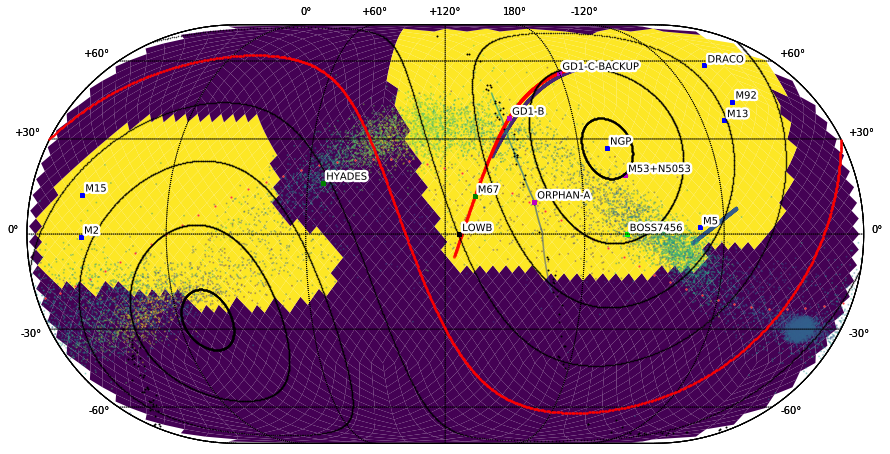

In [297]:
reload(sv_area)
sv_area.plot_footprint(kepler=False,bcontours=[20,40,60,80],only_areas=ssv_patches.keys(),streams=['GD-1','Pal5','Sgr-L10','Orphan'],streams_extra=True)

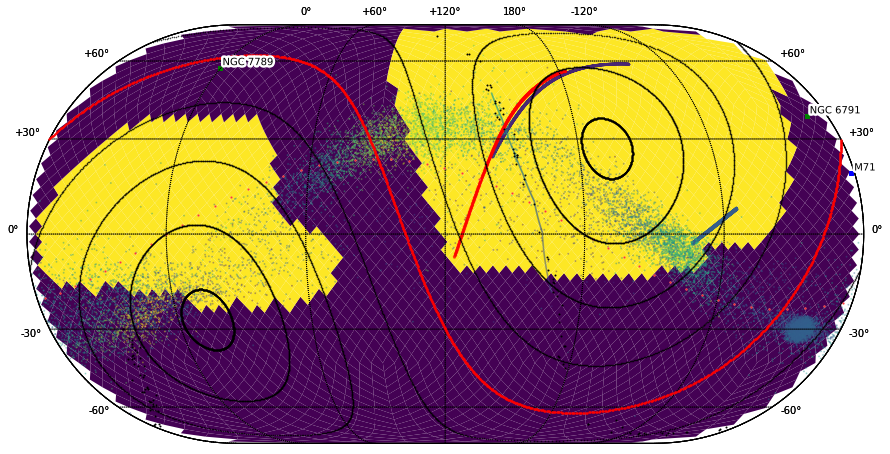

In [298]:
sv_area.plot_footprint(kepler=False,bcontours=[20,40,60,80],only_areas=['M71','NGC 6791','NGC 7789'],streams=['GD-1','Pal5','Sgr-L10','Orphan'],streams_extra=True)

# Tiles

Multiple tiles on a given patch overlap, except for GD1-C (in which they follow the GD1 stream with minimal overlap) and the Hyades (in which they are tiled in a square).

In [337]:
import json


nprimary = 0
for k,v in ssv_patches.items():
    if v['primary'] == 1:
        nprimary += v['ntiles']
        
# Define bright tile pattern

itile        = 75000
ITILE_BACKUP = itile+100
tiles        = list()

name_to_tileids = dict()

# Assign tile IDs to primary tiles first, in RA order
tileid_order = list()
min_ra_tiles = list()

for name,data in ssv_patches.items():
    if data['primary'] == 1:
        rows = np.flatnonzero(ssv_master_tiles['AREA'] == name)
        tileid_order.append(name)
        min_ra_tiles.append(np.max(ssv_master_tiles[rows]['RA']))

tileid_order = [x for _,x in sorted(zip(min_ra_tiles,tileid_order))]
#print(tileid_order)

tileid_order_backup = list()
min_ra_tiles = list()

for name,data in ssv_patches.items():
    if data['primary'] == 0:
        rows = np.flatnonzero(ssv_master_tiles['AREA'] == name)
        tileid_order_backup.append(name)
        min_ra_tiles.append(np.max(ssv_master_tiles[rows]['RA']))

tileid_order_backup = [x for _,x in sorted(zip(min_ra_tiles,tileid_order_backup))]
#print(tileid_order_backup)

tileid_order.extend(tileid_order_backup)
#print(tileid_order)

for jtile,name in enumerate(tileid_order):
    data    = ssv_patches[name]
    ntiles  = data['ntiles']

    # This works fine if we don't specify any offsets
    offsets = data.get('offsets',None)

    if offsets is not None:
        if (len(offsets) != ntiles):
            raise(Exception(name))

    rows     = np.flatnonzero(ssv_master_tiles['AREA'] == name)
    ra_order = np.argsort(ssv_master_tiles[rows]['RA'])
    rows     = rows[ra_order]
    
    #for i in range(0,ntiles):
        # C       = sv_area.SSV_AREAS[name]['coord']
    
    
    if 'rdither_arcmin' in ssv_patches[name]:
        rdither_deg   = ssv_patches[name]['rdither_arcmin']*(1.0/60.0)
        ndither       = ssv_patches[name]['ntiles']
        
        theta_dither  = np.cumsum(np.repeat(2*np.pi/ndither,ndither))
        ra_dither     = rdither_deg*np.sin(theta_dither)
        dec_dither    = rdither_deg*np.cos(theta_dither)
    else:
        ra_dither  = None
        dec_dither = None
        
    for irow,row in enumerate(ssv_master_tiles[rows]):
        C       = coord.SkyCoord(row['RA'],row['DEC'],unit='deg',frame='icrs')
        ra, dec = C.icrs.ra,C.icrs.dec

        if offsets is not None:
            o_r, o_theta = offsets[i]
            # Angle is measured from line of constant ra
            o_ra         = o_r*np.sin(np.deg2rad(o_theta))
            o_dec        = o_r*np.cos(np.deg2rad(o_theta))
            ra  = ra.to(u.deg)  + o_ra*u.deg
            dec = dec.to(u.deg) + o_dec*u.deg
            
        if ra_dither is not None and dec_dither is not None:
            ra  = ra  + ra_dither[irow]*u.deg
            dec = dec + dec_dither[irow]*u.deg
            
        DB1   = Dither(ra,dec,1,0,
                      starttile           = itile,
                      one_pass_per_dither = True,
                      obsconditions       = obsconditions.mask('DARK|GRAY|BRIGHT'))
        
        if not name in name_to_tileids:
            name_to_tileids[name] = list()
        name_to_tileids[name].append(int(DB1.to_table()['TILEID']))        
        tiles.append(DB1)
        ntiles += 1
        itile  += 1
                
    if len(tiles) >= nprimary and itile < ITILE_BACKUP:
        itile = ITILE_BACKUP
    
with open(os.path.join(TILES_DIR,'all_mws_sv_tiles_names_to_ids.json'),'w') as f:
    f.write(json.dumps(name_to_tileids,indent=4))

In [338]:
D = DitherSet(tiles)

In [339]:
dec_dither

In [340]:
D.to_table()

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
75000,63.0631675773,15.8666666667,0,1,0.0,1.0,1.0,1.0,MWSV,7
75001,65.5043891924,15.8666666667,0,1,0.0,1.0,1.0,1.0,MWSV,7
75002,67.9456108076,15.8666666667,0,1,0.0,1.0,1.0,1.0,MWSV,7
75003,70.3868324227,15.8666666667,0,1,0.0,1.0,1.0,1.0,MWSV,7
75004,132.825,11.8,0,1,0.0,1.0,1.0,1.0,MWSV,7
75005,132.825,11.8,0,1,0.0,1.0,1.0,1.0,MWSV,7
75006,149.31928365,37.18726904,0,1,0.0,1.0,1.0,1.0,MWSV,7
75007,152.54030107,40.30048513,0,1,0.0,1.0,1.0,1.0,MWSV,7
75008,156.06453792,43.31780956,0,1,0.0,1.0,1.0,1.0,MWSV,7


In [341]:
tile_to_program = dict([(_,k) for k,v in name_to_tileids.items() for _ in v ])
x = D.to_table()['TILEID','RA','DEC']
x.add_column(Column([tile_to_program[_] for _ in x['TILEID']],'AREA'))
x.pprint(max_lines=-1)

TILEID       RA           DEC          AREA    
------ ------------- ------------- ------------
 75000 63.0631675773 15.8666666667       HYADES
 75001 65.5043891924 15.8666666667       HYADES
 75002 67.9456108076 15.8666666667       HYADES
 75003 70.3868324227 15.8666666667       HYADES
 75004       132.825          11.8          M67
 75005       132.825          11.8          M67
 75006  149.31928365   37.18726904        GD1-B
 75007  152.54030107   40.30048513        GD1-B
 75008  156.06453792   43.31780956        GD1-B
 75009  158.12834749   10.36001699     ORPHAN-A
 75010  159.07757328    7.50387274     ORPHAN-A
 75011  160.91367807    9.71391659     ORPHAN-A
 75012  168.38247475   50.46227707        GD1-C
 75013 192.859477895  27.128252415          NGP
 75014       198.039           0.0     BOSS7456
 75015         199.0          18.3    M53+N5053
 75016         199.0          18.3    M53+N5053
 75017 229.638416667 2.08102777778           M5
 75018 229.638416667 2.08102777778      

In [342]:
# Write these MWS SV tiles
tile_path = os.path.join(TILES_DIR,'all_mws_sv_tiles.fits')
os.makedirs(os.path.dirname(tile_path),exist_ok=True)
D.to_table().write(tile_path,overwrite=True)

In [343]:
rolling_area = None
td = dict(dl   = '** =||=** ',
          area = 'Area name',
        tileid='Tile ID',
        ra='RA (deg)',
        dec='DEC (deg)',
        b='b (deg)',
        priority='Priority',
         notes='Notes')
print('||=**{area:15s}{dl}{tileid:10s}{dl}{ra:12s}{dl}{dec:12s}{dl}{b:6s}{dl}{priority:7s}{dl}{notes:10s}**=||'.format(**td))


for t in D.to_table():
    td = {}
    td['ra']     = t['RA']
    td['dec']    = t['DEC']
    td['tileid'] = t['TILEID']
    
    area = tile_to_program[t['TILEID']]
    if area != rolling_area:
        td['area']  = area
    else:
        td['area']  = ''
    rolling_area = area
    
    b = coord.SkyCoord(t['RA'],t['DEC'],unit='deg',frame='icrs').galactic.b
    td['b'] = b.value
    
    td['priority'] = 'Main SSV' if ssv_patches[area]['primary'] else 'Backup'
    
    print('||{area:15s} || {tileid:10d}|| {ra:12.7f}|| {dec:-12.7f}|| {b:6.1f}|| {priority:7s} || ||'.format(**td))

||=**Area name      ** =||=** Tile ID   ** =||=** RA (deg)    ** =||=** DEC (deg)   ** =||=** b (deg)** =||=** Priority** =||=** Notes     **=||
||HYADES          ||      75000||   63.0631676||   15.8666667||  -25.0|| Main SSV || ||
||                ||      75001||   65.5043892||   15.8666667||  -23.3|| Main SSV || ||
||                ||      75002||   67.9456108||   15.8666667||  -21.4|| Main SSV || ||
||                ||      75003||   70.3868324||   15.8666667||  -19.6|| Main SSV || ||
||M67             ||      75004||  132.8250000||   11.8000000||   31.9|| Main SSV || ||
||                ||      75005||  132.8250000||   11.8000000||   31.9|| Main SSV || ||
||GD1-B           ||      75006||  149.3192836||   37.1872690||   52.1|| Main SSV || ||
||                ||      75007||  152.5403011||   40.3004851||   54.3|| Main SSV || ||
||                ||      75008||  156.0645379||   43.3178096||   56.2|| Main SSV || ||
||ORPHAN-A        ||      75009||  158.1283475||   10.3600170||

In [345]:
print(tile_path)

/global/u1/a/apcooper/projects/ssv_plan/global/tiles/all_mws_sv_tiles.fits


In [307]:
dither_polys = list()
for d in D.dithers:
    dither_polys.append(d.to_spoly())

In [308]:
dither_polys[0]

[SingleSphericalPolygon(array([[ 0.46345504,  0.85129784,  0.24597035],
       [ 0.45602959,  0.83765841,  0.30060838],
       [ 0.40773229,  0.86220008,  0.30060838],
       [ 0.41437132,  0.87623912,  0.24597035],
       [ 0.46345504,  0.85129784,  0.24597035]]), array([ 0.43553863,  0.85761466,  0.27350173]))]

In [309]:
def plot_sky_circle(x, y, radius, alpha=0.2,**kwargs):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    pl.fill(xx, yy, alpha=alpha,**kwargs)

def plot_tile(ra, dec, alpha=0.2):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    plot_sky_circle(ra, dec, tile_radius, alpha=alpha)

def plot_tiles(tiles,alpha=0.2):
    for i in range(len(tiles)):
        plot_tile(tiles['RA'][i], tiles['DEC'][i],alpha=alpha)
        
def plot_sky_hexagon(ra,dec,radius=None): 
    ax = pl.gca()
    if radius is None:
        radius = desimodel.focalplane.get_tile_radius_deg()
    H = RegularPolygon((ra,dec),6,
                       radius,
                       orientation=np.pi/6.0)
    x = H.get_verts()[:,0]    
    y = H.get_verts()[:,1]
    
    x = ra + (x-ra)*np.cos(np.radians(dec))
    
    P = Polygon(np.vstack([x,y]).T,edgecolor='k',facecolor='None')
    #P.update(H)
    ax.add_patch(P)

In [310]:
def plot_gd1_ting():
    ra       = np.linspace(123.860301355618, 183.37915611130998, 1000)
    dec_func = np.poly1d([-1.80670575e-07,  1.40950934e-04, -4.36119783e-02,  6.67035494e+00,  -5.01780078e+02, 1.47751518e+04])
    dec      = dec_func(ra)
    pl.plot(ra,dec,c='b',ls='--',lw=2)
    return

def plot_gd1():    
    v = sv_area.stdict['GD-1']
    ra, dec = v['RA_deg'],v['DEC_deg']
    pl.scatter(ra,dec,c='b',s=1)
    return

def plot_orphan():    
    v = sv_area.stdict['Orphan']
    ra, dec = v['RA_deg'],v['DEC_deg']
    pl.plot(ra,dec,c='g',ls='--')
    return

def decorate_GD1B(ax):
    plot_gd1_ting()
    plot_gd1()
    return

def decorate_GD1C(ax):
    plot_gd1_ting()
    plot_gd1()
    return

def decorate_GD1CBACKUP(ax):
    plot_gd1_ting()
    plot_gd1()
    return

def decorate_MWS2(ax):
    plot_gd1_ting()
    plot_gd1()
    plot_orphan()
    return

def decorate_M67(ax):
    plot_gd1_ting()
    plot_gd1()
    return

def decorate_ORPHANA(ax):
    plot_orphan()
    return

def decorate_DRACO(ax):
    # R_H = 10 arcmin according to Alan McConnachie
    c = coord.SkyCoord('17 20 12.4','57 54 55',unit='hour,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*10*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*10*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_M13(ax):
    # R_H = 1.6 arcmin according to Bill Harris
    c = coord.SkyCoord('16 41 41.24','36 27 35.5',unit='hour,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*1.69*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*1.69*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_M67(ax):
    c = coord.SkyCoord('132.8250  +11.8000',unit='deg,deg',frame='icrs')
    
    # R85 for all stars from Carrera+ 2019
    plot_sky_circle(c.ra,c.dec,37*u.arcmin,linestyle='-.',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_HYADES(ax):
    c = coord.SkyCoord('066.72500  +15.86667',unit='deg,deg',frame='icrs')
    
    # Very roughly r_50 = 4.1pc, distance 47pc
    plot_sky_circle(c.ra,c.dec,4.1*u.deg,linestyle='-.',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_M5(ax):
    c = coord.SkyCoord('15 18 33.22  +02 04 51.7',unit='hour,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*1.77*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*1.77*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_M92(ax):
    c = coord.SkyCoord('17 17 07.39  +43 08 09.4',unit='hour,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*1.02*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*1.02*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_M15(ax):
    c = coord.SkyCoord('21 29 58.33  +12 10 01.2',unit='hour,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*1.0*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*1.0*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    return

def decorate_M53_N5053(ax):
    # M503
    c = coord.SkyCoord('13 12 55.25 +18 10 05.4',unit='hour,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*1.31*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*1.31*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    
    # Centre of field
    cc = sv_area.SSV_AREAS['M53+N5053']['coord']    
    #plot_sky_circle(cc.ra,cc.dec,0.75*u.deg,linestyle=':',edgecolor='r',lw=2,facecolor='none')

    # NGC 5053
    c = coord.SkyCoord('199.11288  +17.70025',unit='deg,deg',frame='icrs')
    plot_sky_circle(c.ra,c.dec,3*2.61*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    plot_sky_circle(c.ra,c.dec,10*2.61*u.arcmin,linestyle='--',edgecolor='k',lw=2,facecolor='none')
    return

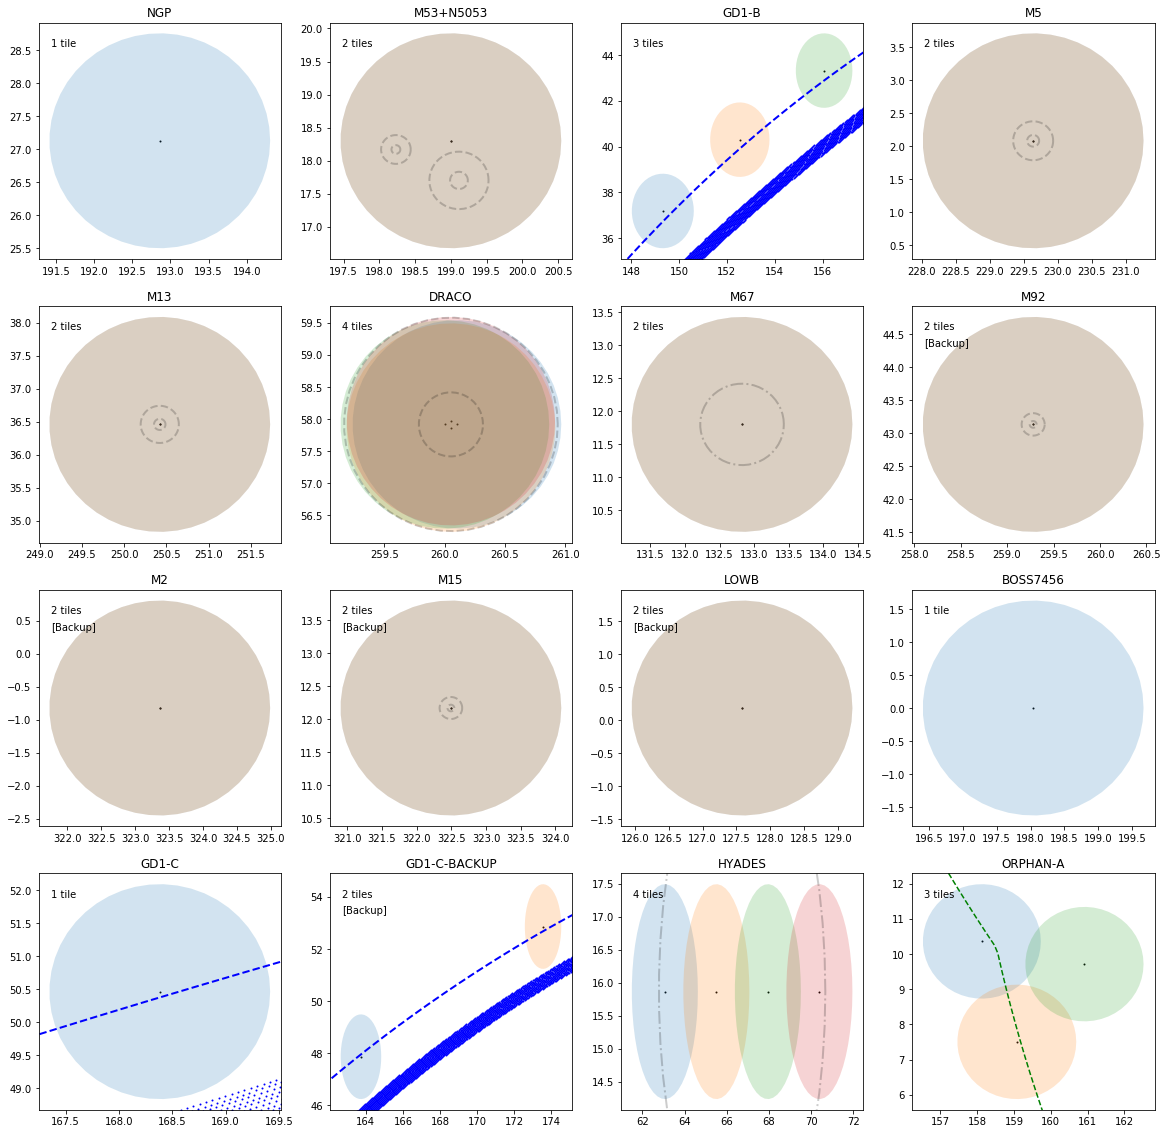

In [311]:
t = D.to_table()
f = pl.figure(figsize=(20,20))

patch_names = list(a.keys())
for iax in range(0,len(patch_names)):
    ax = f.add_subplot(4,4,iax+1)

    name     = patch_names[iax]
    tile_ids = name_to_tileids[name]
    for tile_id in tile_ids:
        irow = np.flatnonzero(t['TILEID'] == tile_id)
        plot_tile(t['RA'][irow],t['DEC'][irow])
        pl.scatter(t['RA'][irow],t['DEC'][irow],s=1,marker='o',color='k')
        
    ax.set_title(name)
    pl.axis('auto')
    
    pl.text(0.05,0.9,'{} tile{}'.format(len(tile_ids),'s' if len(tile_ids) > 1 else ''),transform=ax.transAxes)
    
    if ssv_patches[patch_names[iax]]['primary'] == 0:
        pl.text(0.05,0.83,'[Backup]',transform=ax.transAxes)

    pl.autoscale(False)
    decorator = 'decorate_{}'.format((name.replace('-','').replace('+','_')))
    if decorator in locals():
        locals()[decorator](ax) 

In [261]:
# Read the sweeps to use for targeting directly 
SWEEPS_RESET = False

SWEEPS_ROOT  = '/project/projectdirs/cosmo/data/legacysurvey/dr8/'
SWEEPS_DIR_N = '/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep'
SWEEPS_DIR_S = '/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep'

# Note that some bricks exist in both the north and the south trees, with different targets.

SWEEPS_VER = '8.0'
SWEEPS_HEADER_CACHE = os.path.join(ROOT_DIR,'cache/sweeps/')

for northsouth in ['north','south']:
    if not os.path.exists(os.path.join(SWEEPS_HEADER_CACHE,northsouth,SWEEPS_VER)):
        os.makedirs(os.path.join(SWEEPS_HEADER_CACHE,northsouth,SWEEPS_VER))

sweep_headers = list()
for _ in io.list_sweepfiles(os.path.join(SWEEPS_DIR_N,SWEEPS_VER)):
    _base  = os.path.basename(_)
    _cache = os.path.join(SWEEPS_HEADER_CACHE,'north',SWEEPS_VER,_base)
    if not os.path.exists(_cache) or SWEEPS_RESET:
        h = fits.getheader(_)
        h.tofile(_cache,overwrite=True)
    else:
        h = astropy.io.fits.header.Header.fromfile(_cache)
    sweep_headers.append(h)
    
for _ in io.list_sweepfiles(os.path.join(SWEEPS_DIR_S,SWEEPS_VER)):
    _base  = os.path.basename(_)
    _cache = os.path.join(SWEEPS_HEADER_CACHE,'south',SWEEPS_VER,_base)
    if not os.path.exists(_cache) or SWEEPS_RESET:
        h = fits.getheader(_)
        h.tofile(_cache,overwrite=True)
    else:
        h = astropy.io.fits.header.Header.fromfile(_cache)
    sweep_headers.append(h)
    
original_sweep_files = io.list_sweepfiles(os.path.join(SWEEPS_DIR_N,SWEEPS_VER))
original_sweep_files.extend(io.list_sweepfiles(os.path.join(SWEEPS_DIR_S,SWEEPS_VER)))

nsweeps = len(sweep_headers)
print('Have {} sweep files'.format(nsweeps))

Have 723 sweep files


In [262]:
# Which sweeps cover our tiles?
sweep_files = io.list_sweepfiles(os.path.join(SWEEPS_HEADER_CACHE,'north',SWEEPS_VER))
sweep_files.extend(io.list_sweepfiles(os.path.join(SWEEPS_HEADER_CACHE,'south',SWEEPS_VER)))

In [263]:
if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly
    
sweep_polys     = list()
all_sweep_polys = list()
sweeps_for_sv   = list()

for f in sweep_files:
    h = fitsio.read_header(f)
    corners_ra  = [h['RAMIN'],h['RAMIN'],h['RAMAX'],h['RAMAX']]
    corners_dec = [h['DECMIN'],h['DECMAX'],h['DECMAX'],h['DECMIN']]
    sweep_poly  = spoly.SphericalPolygon.from_radec(corners_ra,corners_dec)
    all_sweep_polys.append(sweep_poly)

    for dither_poly in dither_polys:
        intersection = sweep_poly.intersection(dither_poly)
        if len(intersection) > 0:
            sweep_polys.append(sweep_poly)
            sweeps_for_sv.append(f)

In [264]:
print(len(sweeps_for_sv))

75


In [265]:
sweeps_for_sv

['/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-170p045-180p050.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-250p035-260p040.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-250p035-260p040.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-160p045-170p050.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-160p045-170p050.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-140p035-150p040.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-240p030-250p035.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-240p030-250p035.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-150p040-160p045.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north/8.0/sweep-150p040-160p045.fits',
 '/global/u1/a/apcooper/projects/ssv_plan/cache/sweeps/north

In [266]:
# sv_area.plot_footprint(sweep_polys=all_sweep_polys,streams=['GD-1','Pal5','Sgr-L10'])

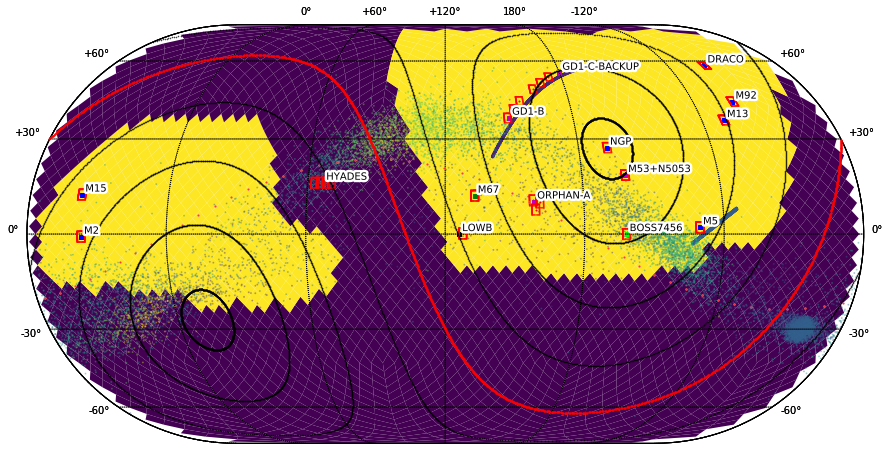

In [316]:
sv_area.plot_footprint(only_areas=ssv_patches.keys(),dither_polys=dither_polys,streams=['GD-1','Pal5','Sgr-L10'])

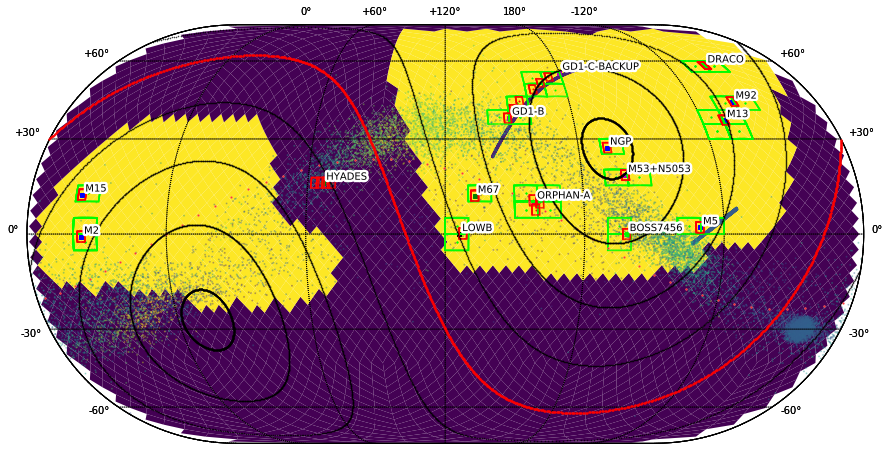

In [312]:
sv_area.plot_footprint(sweep_polys=sweep_polys,only_areas=ssv_patches.keys(),dither_polys=dither_polys,streams=['GD-1','Pal5','Sgr-L10'])

In [313]:
original_sweep_files_rel = [os.path.relpath(_,start=SWEEPS_ROOT) for _ in original_sweep_files]

sweep_index = list()
for _ in sweeps_for_sv:
    rel_path = os.path.relpath(_,start=SWEEPS_HEADER_CACHE)
    l        = rel_path.split(os.path.sep)
    l.insert(1,'sweep')
    rel_path = os.path.join(*l)
    
    idx      = original_sweep_files_rel.index(rel_path)
    sweep_index.append(idx)

sweep_paths     = [original_sweep_files[_] for _ in sweep_index]

In [314]:
# Write these MWS SV tiles
sweeps_json_path = os.path.join(TILES_DIR,'sweeps.json')
with open(sweeps_json_path,'w') as f:
    # Note the dict(zip()) here takes out the duplicates
    f.write(json.dumps(dict(zip(sweep_index,sweep_paths)),indent=2))

In [315]:
!cat $sweeps_json_path

{
  "9": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-170p045-180p050.fits",
  "28": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-250p035-260p040.fits",
  "43": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-160p045-170p050.fits",
  "60": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-140p035-150p040.fits",
  "109": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-240p030-250p035.fits",
  "122": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-150p040-160p045.fits",
  "123": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-240p035-250p040.fits",
  "124": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-260p055-270p060.fits",
  "175": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-150p035-160p040.fits",
  "185": "/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sw

# Observing Times

In [81]:
import astroplan


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [82]:
from astroplan import Observer, FixedTarget
from astroplan import AltitudeConstraint, AirmassConstraint, AtNightConstraint
from astropy.time import Time

desi = Observer.at_site('kpno')

targets = [FixedTarget(coord=a['coord'].icrs,name=name) for name, a in sv_area.SSV_AREAS.items()]

constraints = [AltitudeConstraint(10*u.deg, 80*u.deg),
               AirmassConstraint(2), 
               AtNightConstraint.twilight_civil()]


In [83]:
time_range = Time(["2019-10-01 6:00", "2020-06-02 6:00"])

In [84]:
astroplan.observability_table(constraints,desi,targets,time_range=time_range)

target name,ever observable,always observable,fraction of time observable
str9,bool,bool,float64
DRACO,True,False,0.174574829932
MWS1,True,False,0.219727891156
MWS2,True,False,0.22074829932
ORPHAN-A,True,False,0.222959183673
G15,True,False,0.157908163265
G12,True,False,0.186734693878
M53+N5053,True,False,0.207823129252
NGP,True,False,0.191071428571
M92,True,False,0.15824829932


In [ ]:
astroplan

# BOSS plates

In [74]:
!wget https://dr15.sdss.org/sas/dr15/eboss/spectro/redux/platelist.fits

--2019-07-09 22:59:42--  https://dr15.sdss.org/sas/dr15/eboss/spectro/redux/platelist.fits
Resolving dr15.sdss.org (dr15.sdss.org)... 2001:1948:414:13::80, 155.101.19.80
Connecting to dr15.sdss.org (dr15.sdss.org)|2001:1948:414:13::80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1961280 (1.9M) [application/octet-stream]
Saving to: ‘platelist.fits’

100%[======================================>] 1,961,280   --.-K/s   in 0.1s    

2019-07-09 22:59:42 (14.3 MB/s) - ‘platelist.fits’ saved [1961280/1961280]



In [87]:
from astropy.table import Table
import healpy as hp

In [81]:
boss_plates = Table(fits.getdata('platelist.fits'))

In [85]:
boss_plates.colnames

['PLATE',
 'TILEID',
 'MJD',
 'RUN2D',
 'RUN1D',
 'RACEN',
 'DECCEN',
 'EPOCH',
 'CARTID',
 'TAI',
 'TAI_BEG',
 'TAI_END',
 'AIRMASS',
 'EXPTIME',
 'MAPNAME',
 'SURVEY',
 'PROGRAMNAME',
 'CHUNK',
 'PLATEQUALITY',
 'PLATESN2',
 'DEREDSN2',
 'QSURVEY',
 'MJDLIST',
 'NEXP',
 'NEXP_B1',
 'NEXP_B2',
 'NEXP_R1',
 'NEXP_R2',
 'EXPT_B1',
 'EXPT_B2',
 'EXPT_R1',
 'EXPT_R2',
 'SN2_G1',
 'SN2_R1',
 'SN2_I1',
 'SN2_G2',
 'SN2_R2',
 'SN2_I2',
 'DERED_SN2_G1',
 'DERED_SN2_R1',
 'DERED_SN2_I1',
 'DERED_SN2_G2',
 'DERED_SN2_R2',
 'DERED_SN2_I2',
 'GOFFSTD',
 'GRMSSTD',
 'ROFFSTD',
 'RRMSSTD',
 'IOFFSTD',
 'IRMSSTD',
 'GROFFSTD',
 'GRRMSSTD',
 'RIOFFSTD',
 'RIRMSSTD',
 'GOFFGAL',
 'GRMSGAL',
 'ROFFGAL',
 'RRMSGAL',
 'IOFFGAL',
 'IRMSGAL',
 'GROFFGAL',
 'GRRMSGAL',
 'RIOFFGAL',
 'RIRMSGAL',
 'NGUIDE',
 'SEEING20',
 'SEEING50',
 'SEEING80',
 'RMSOFF20',
 'RMSOFF50',
 'RMSOFF80',
 'AIRTEMP',
 'XSIGMA',
 'XSIGMIN',
 'XSIGMAX',
 'WSIGMA',
 'WSIGMIN',
 'WSIGMAX',
 'XCHI2',
 'XCHI2MIN',
 'XCHI2MAX',
 'SKYCHI2

In [100]:
hp.nside2pixarea(2*8,degrees=True)

13.428698323378669

In [177]:
NSIDE = 2**4
npix  = hp.nside2npix(NSIDE)
bins  = np.zeros(npix, dtype=np.int64)
boss_coord = coord.SkyCoord(boss_plates['RACEN'],boss_plates['DECCEN'],frame='icrs',unit='deg')

representation = boss_coord.represent_as(coord.UnitSphericalRepresentation)
lon, lat = representation.lon, representation.lat

lon = boss_coord.ra.degree
lat = boss_coord.dec.degree

ipix     = hp.ang2pix(NSIDE,lon,lat,lonlat=True,nest=True)

for _ in range(0,len(ipix)):
    bins[ipix[_]] += boss_plates['N_STAR'][_]

In [178]:
boss_plates['N_STAR'].max()

912

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

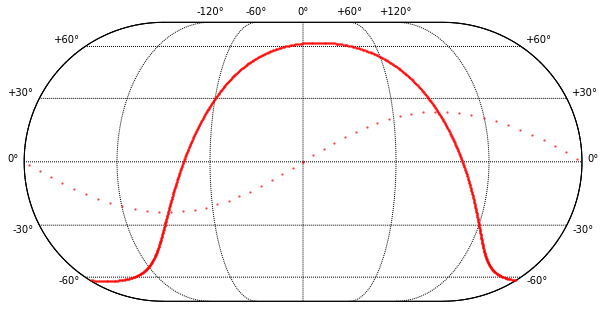

In [184]:
pl.figure(figsize=(10,8))
bm = desiutil.plots.init_sky(ra_center=0)
w  = (lon >0) & (lat >0 ) & (lon < 300) & (lon < 300)
bm.scatter(lon[w],lat[w],latlon=True)
#desiutil.plots.plot_healpix_map(desiutil.plots.prepare_data(bins,clip_lo=1,clip_hi=100),nest=True)


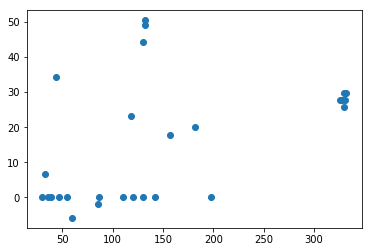

In [186]:
w = boss_plates['N_STAR'] > 300
pl.scatter(lon[w],lat[w])

In [187]:
boss_plates[w]

PLATE,TILEID,MJD,RUN2D,RUN1D,RACEN,DECCEN,EPOCH,CARTID,TAI,TAI_BEG,TAI_END,AIRMASS,EXPTIME,MAPNAME,SURVEY,PROGRAMNAME,CHUNK,PLATEQUALITY,PLATESN2,DEREDSN2,QSURVEY,MJDLIST,NEXP,NEXP_B1,NEXP_B2,NEXP_R1,NEXP_R2,EXPT_B1,EXPT_B2,EXPT_R1,EXPT_R2,SN2_G1,SN2_R1,SN2_I1,SN2_G2,SN2_R2,SN2_I2,DERED_SN2_G1,DERED_SN2_R1,DERED_SN2_I1,DERED_SN2_G2,DERED_SN2_R2,DERED_SN2_I2,GOFFSTD,GRMSSTD,ROFFSTD,RRMSSTD,IOFFSTD,IRMSSTD,GROFFSTD,GRRMSSTD,RIOFFSTD,RIRMSSTD,GOFFGAL,GRMSGAL,ROFFGAL,RRMSGAL,IOFFGAL,IRMSGAL,GROFFGAL,GRRMSGAL,RIOFFGAL,RIRMSGAL,NGUIDE,SEEING20,SEEING50,SEEING80,RMSOFF20,RMSOFF50,RMSOFF80,AIRTEMP,XSIGMA,XSIGMIN,XSIGMAX,WSIGMA,WSIGMIN,WSIGMAX,XCHI2,XCHI2MIN,XCHI2MAX,SKYCHI2,SCHI2MIN,SCHI2MAX,FBADPIX,FBADPIX1,FBADPIX2,N_TOTAL,N_GALAXY,N_QSO,N_STAR,N_UNKNOWN,N_SKY,N_TARGET_MAIN,N_TARGET_LRG1,N_TARGET_LRG2,N_TARGET_ELG,N_TARGET_QSO,SUCCESS_MAIN,SUCCESS_LRG1,SUCCESS_LRG2,SUCCESS_ELG,SUCCESS_QSO,STATUS2D,STATUSCOMBINE,STATUS1D,PUBLIC,QUALCOMMENTS
int32,int32,int32,str7,str7,float32,float32,float32,int32,float64,float64,float64,float32,float32,str14,str5,str27,str14,str4,float32,float32,int32,str35,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,str7,str7,str7,str4,str83
5959,14233,56214,v5_10_0,v5_10_0,329.977,25.7452,2012.6,12,0.0,4856895818.0,4856899666.85,1.08516,3603.37,5959-56214-01,boss,boss,boss28,good,12.4175,12.4175,1,56214,16,4,4,4,4,3603.37,3603.41,3603.37,3603.41,13.4089,41.4796,28.1335,12.4175,36.4042,27.2918,13.4089,41.4796,28.1335,12.4175,36.4042,27.2918,0.016367,0.080538,-0.00524712,0.0944565,-0.00567818,0.107774,0.00150299,0.0433775,-0.014061,0.036456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,1.34638,1.40845,1.48683,0.00907534,0.0171647,0.0252793,6.45,1.09468,1.02669,1.24541,1.12846,1.09421,1.16005,0.0,0.0,0.0,1.04642,0.982434,1.18949,0.0341804,0.0402021,0.0281343,1000,523,39,301,57,80,0,155,441,0,177,0.0,95.4839,86.1678,0.0,20.339,Done,Done,Done,DR11,
5961,14235,56460,v5_10_0,v5_10_0,332.22,29.6058,2012.6,18,0.0,4878176255.0,4878182070.85,1.16415,5405.03,5961-56457-01,boss,boss,boss28,good,13.8837,13.8837,1,56460,24,6,6,6,6,5405.12,5405.03,5405.12,5405.03,15.532,56.9231,45.8786,13.8837,52.7297,42.9381,15.532,56.9231,45.8786,13.8837,52.7297,42.9381,0.00315857,0.071612,-0.00629234,0.0517136,-0.00631714,0.0676816,0.0184956,0.0788406,-0.0163498,0.0426591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,1.20612,1.2684,1.31648,0.0139452,0.0215273,0.0279714,15.4,1.07551,1.01251,1.16178,1.10959,1.07094,1.14028,0.0,0.0,0.0,1.01303,0.955974,1.13296,0.0245736,0.0318457,0.0172721,1000,450,50,355,65,80,0,183,332,0,177,0.0,96.7213,81.9277,0.0,24.8588,Done,Done,Done,DR12,
5963,14237,56191,v5_10_0,v5_10_0,330.866,27.6732,2012.6,11,0.0,4854913550.0,4854918378.85,1.09984,4504.13,5963-56191-01,boss,boss,boss28,good,10.7333,10.7333,1,56191,20,5,5,5,5,4504.13,4504.23,4504.13,4504.23,10.7333,42.4575,37.5496,13.7246,48.5154,40.9436,10.7333,42.4575,37.5496,13.7246,48.5154,40.9436,0.00115871,0.0768549,0.00805664,0.0739115,0.0082159,0.0837085,0.00781727,0.0497898,0.00345039,0.0345181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,1.27956,1.37088,1.55312,0.00831912,0.0145037,0.0235786,14.86,1.07407,0.99785,1.20723,1.10946,1.06413,1.14214,0.0,0.0,0.0,1.01415,0.951641,1.1075,0.0313549,0.0415739,0.0211154,1000,486,38,353,43,80,0,167,385,0,146,0.0,94.6108,85.7143,0.0,22.6027,Done,Done,Done,DR11,
5964,14238,56098,v5_10_0,v5_10_0,328.286,27.7623,2012.6,17,0.0,4846896639.0,4846902453.84,1.22414,5404.89,5964-56098-01,

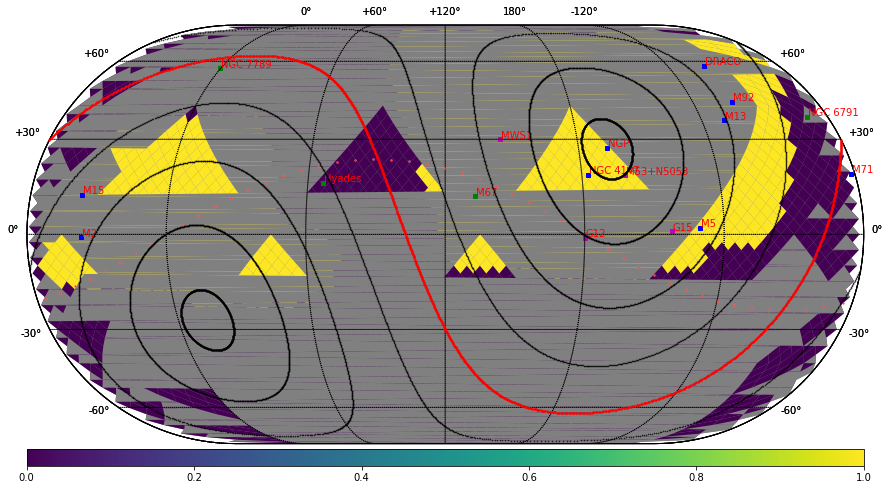

In [188]:
sv_area.plot_footprint()

In [13]:
path = '/global/project/projectdirs/desi/datachallenge/svdc-summer2019/svdc2019c/survey/SV_MWS-tiles.fits'

In [15]:
t = Table(fits.getdata(path))

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<desiutil.plots.init_sky.<locals>.BasemapWithEllipse at 0x2aaab5738748>

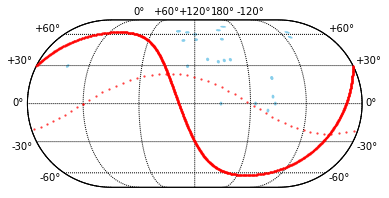

In [16]:
desiutil.plots.plot_sky_circles(t['RA'],t['DEC'])